# CIENCIA DE DATOS - INCENDIOS FORESTALES - UTN-FRBA
Barreto, Romina 

Pulella, María Belén

Vigón, Lucila Belén

In [1]:
#Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
import geopandas
from geopandas import GeoDataFrame

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My Drive/Ciencia_de_Datos/

/content/drive/My Drive/Ciencia_de_Datos


In [4]:
#Importamos el primer dataset
df = pd.read_csv('/content/drive/My Drive/Ciencia_de_Datos/incendios-cantidad-causas-provincia.csv',encoding='latin-1',delimiter=";")
 
#Importamos el segundo dataset
df1 = pd.read_csv('/content/drive/My Drive/Ciencia_de_Datos/superficie-incendiada-provincias-tipo-de-vegetacion.csv',encoding='latin-1',delimiter=";")

#Importamos Un mapa de Argentina para usar con GeoPandas
provincias1 = '/content/drive/My Drive/Ciencia_de_Datos/provincia.shp'
map_data = geopandas.read_file(provincias1)

#Observamos el tamaño de las bases
print(f'Shape incendios x causas:{np.shape(df)},Shape Superficie afectada x tipo:{np.shape(df1)}')

Shape incendios x causas:(999, 26),Shape Superficie afectada x tipo:(585, 8)


In [5]:
#Analizamos los valores nulos
col_nulls = df.isnull().any()
total_nulls = df.isnull().sum().sort_values(ascending=False)
percent_nulls = (df.isnull().sum()/df.isnull().count()).sort_values(ascending= True)
missing_data = pd.concat([total_nulls, percent_nulls], axis=1, keys=['Total', 'Percent'])

total_nulls1=df1.isnull().sum().sort_values(ascending=False)
percent_nulls1 = (df1.isnull().sum()/df1.isnull().count()).sort_values(ascending= True)
missing_data1 = pd.concat([total_nulls1, percent_nulls1], axis=1, keys=['Total', 'Percent'])

display(missing_data, missing_data1)

,Total,Percent
Unnamed: 25,999,1.000000
Unnamed: 15,999,1.000000
Unnamed: 7,999,1.000000
Unnamed: 8,999,1.000000
Unnamed: 9,999,1.000000
Unnamed: 10,999,1.000000
Unnamed: 11,999,1.000000
Unnamed: 24,999,1.000000
Unnamed: 13,999,1.000000
Unnamed: 14,999,1.000000


,Total,Percent
superficie_afectada_por_incendios_sin_determinar_hectareas,0,0.0
superficie_afectada_por_incendios_pastizal_hectareas,0,0.0
superficie_afectada_por_incendios_arbustal_hectareas,0,0.0
superficie_afectada_por_incendios_bosque_cultivado_hectareas,0,0.0
superficie_afectada_por_incendios_bosque_nativo_hectareas,0,0.0
superficie_afectada_por_incendios_total_hectareas,0,0.0
superficie_afectada_por_incendios_provincia,0,0.0
superficie_afectada_por_incendios_anio,0,0.0


In [6]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')] #Eliminamos las columnas completamente nulas
df_nulls=df[df.incendio_anio.isnull()]
np.shape(df_nulls)

(414, 7)

In [7]:
df=df.loc[0:584]
display(np.shape(df))
df.incendio_anio.isnull()

(585, 7)

0      False
1      False
2      False
3      False
4      False
       ...  
580    False
581    False
582    False
583    False
584    False
Name: incendio_anio, Length: 585, dtype: bool

In [8]:
#Renombramos las columnas para poder formar un unico dataset con df y df1
df=df.rename(columns={'incendio_anio':'year','incendio_provincia':'provincia'})
df1=df1.rename(columns={'superficie_afectada_por_incendios_anio':'year','superficie_afectada_por_incendios_provincia':'provincia'})
df=df.replace({'Ciudad Autónoma de Buenos Aires':'CABA'})
df1=df1.replace({'Ciudad Autónoma de Buenos Aires':'CABA'})
df1=df1.replace({'Ciudad Autónoma de Bs As':'CABA'})

In [9]:
#Formamos el dataset sobre el cual vamos a trabajar
df_df1=pd.merge(df, df1, on=['year','provincia'])
display(df_df1.head(5))
df_df1.shape

,year,provincia,incendio_total_numero,incendio_negligencia_numero,incendio_intencional_numero,incendio_natural_numero,incendio_desconocida_numero,superficie_afectada_por_incendios_total_hectareas,superficie_afectada_por_incendios_bosque_nativo_hectareas,superficie_afectada_por_incendios_bosque_cultivado_hectareas,superficie_afectada_por_incendios_arbustal_hectareas,superficie_afectada_por_incendios_pastizal_hectareas,superficie_afectada_por_incendios_sin_determinar_hectareas
0,1993.0,Buenos Aires,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
1,1993.0,Catamarca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
2,1993.0,Chaco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
3,1993.0,Chubut,21.0,18.0,0.0,0.0,3.0,149.5,10.0,6.25,0.0,133.25,0.0
4,1993.0,Córdoba,151.0,0.0,0.0,0.0,151.0,232941.0,59995.0,250.00,0.0,172696.00,0.0


(585, 13)

In [10]:
#Reemplazamos los valores nulos por cero
df_df1.fillna(0)

,year,provincia,incendio_total_numero,incendio_negligencia_numero,incendio_intencional_numero,incendio_natural_numero,incendio_desconocida_numero,superficie_afectada_por_incendios_total_hectareas,superficie_afectada_por_incendios_bosque_nativo_hectareas,superficie_afectada_por_incendios_bosque_cultivado_hectareas,superficie_afectada_por_incendios_arbustal_hectareas,superficie_afectada_por_incendios_pastizal_hectareas,superficie_afectada_por_incendios_sin_determinar_hectareas
0,1993.0,Buenos Aires,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000,0.000,0.0
1,1993.0,Catamarca,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000,0.000,0.0
2,1993.0,Chaco,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000,0.000,0.0
3,1993.0,Chubut,21.0,18.0,0.0,0.0,3.0,149.50,10.00,6.25,0.000,133.250,0.0
4,1993.0,Córdoba,151.0,0.0,0.0,0.0,151.0,232941.00,59995.00,250.00,0.000,172696.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,2017.0,Santa Cruz,17.0,17.0,0.0,0.0,0.0,303201.00,0.00,0.00,5.200,298001.000,0.0
581,2017.0,Santa Fe,1096.0,247.0,596.0,15.0,238.0,1303.00,75.00,123.00,101.000,1004.000,0.0
582,2017.0,Santiago del Estero,99.0,0.0,0.0,1.0,98.0,1784.00,10.00,31.00,752.000,991.000,0.0
583,2017.0,Tierra del Fuego,7.0,7.0,0.0,0.0,0.0,5214.00,1567.00,2134.00,0.735,0.778,0.0


In [11]:
np.max(df_df1)

year                                                                   2017
provincia                                                           Tucumán
incendio_total_numero                                                 10321
incendio_negligencia_numero                                            2693
incendio_intencional_numero                                            1662
incendio_natural_numero                                                 836
incendio_desconocida_numero                                            7530
superficie_afectada_por_incendios_total_hectareas               9.38045e+08
superficie_afectada_por_incendios_bosque_nativo_hectareas       3.53933e+09
superficie_afectada_por_incendios_bosque_cultivado_hectareas    1.63266e+09
superficie_afectada_por_incendios_arbustal_hectareas            3.75679e+09
superficie_afectada_por_incendios_pastizal_hectareas            6.74609e+09
superficie_afectada_por_incendios_sin_determinar_hectareas           453950
dtype: objec

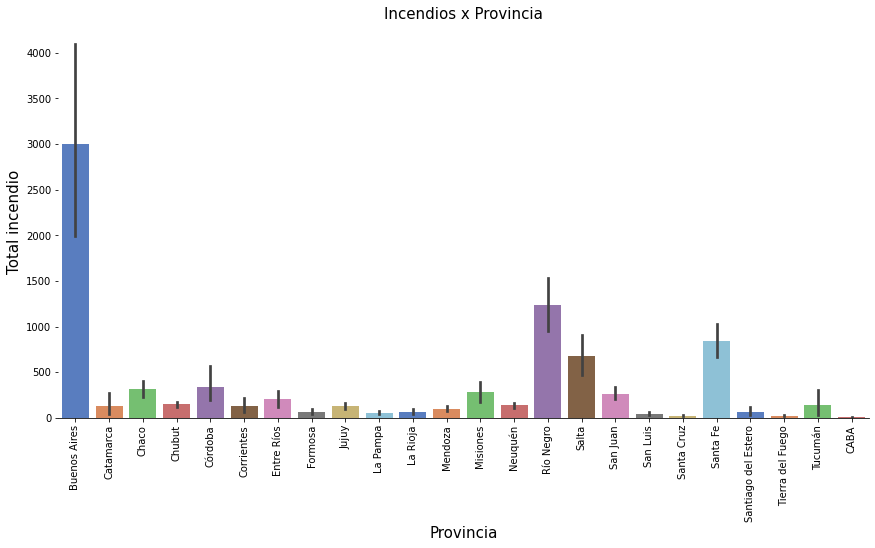

In [12]:
#Realizamos un plot que nos permite visualizar el numero total de incendios en las diferentes provincias desde 1993 hasta 2017
g = sns.catplot(x='provincia',y='incendio_total_numero',data=df, kind="bar", height = 6,aspect=2,palette = "muted")
g.despine(left=True)
g.set_xticklabels(rotation=90, size=10)
plt.xlabel("Provincia",size=15)
plt.ylabel("Total incendio",size=15)
plt.title('Incendios x Provincia',size = 15)
plt.show()

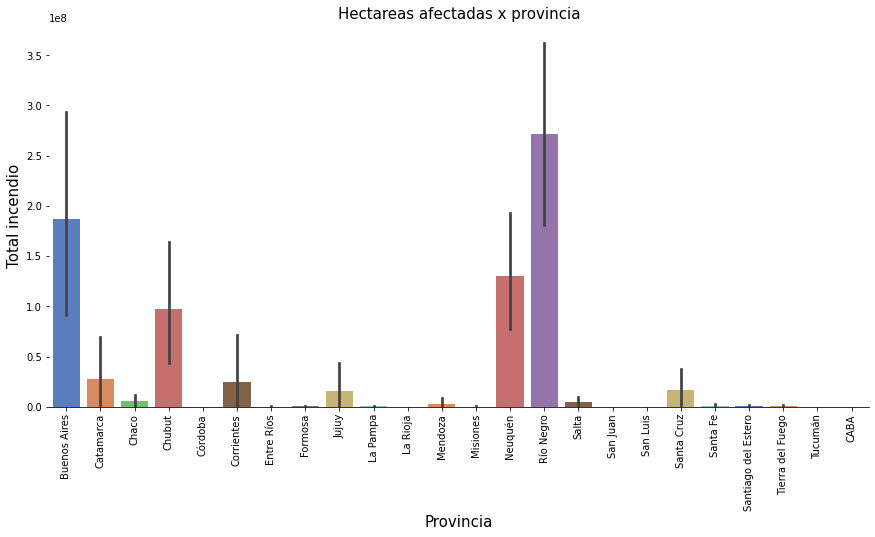

In [13]:
#Realizamos un plot para ver las hectareas afectadas por provincia desde 1993 hasta 2017
#Primero pasamos todos los valores a float
df_df1['superficie_afectada_por_incendios_total_hectareas']=df_df1.superficie_afectada_por_incendios_total_hectareas.astype(float)
df_df1['superficie_afectada_por_incendios_bosque_nativo_hectareas']=df_df1.superficie_afectada_por_incendios_bosque_nativo_hectareas.astype(float)
df_df1['superficie_afectada_por_incendios_bosque_cultivado_hectareas']=df_df1.superficie_afectada_por_incendios_bosque_cultivado_hectareas.astype(float)
df_df1['superficie_afectada_por_incendios_pastizal_hectareas']= df_df1.superficie_afectada_por_incendios_pastizal_hectareas.astype(float)

g_hectareas = sns.catplot(x='provincia',y='superficie_afectada_por_incendios_total_hectareas',data=df1, kind="bar", height = 6 ,aspect=2,palette = "muted")
g_hectareas.despine(left=True)
g_hectareas.set_xticklabels(rotation=90, size=10)
plt.xlabel("Provincia",size=15)
plt.ylabel("Total incendio",size=15)
plt.title('Hectareas afectadas x provincia',size = 15)
plt.show()

Si bien vemos que Buenos Aires es la provincia con mayor cantidad de incendios en el período 1993-2017, la provincia con mayor superficie afectada es Rio Negro

In [14]:
#Procedemos a calcular los incendios totales por año y por provincia
df_df1['incendio_total_numero']=df_df1['incendio_total_numero'].astype(int)
df_df1_provincia=pd.pivot_table(df_df1,values='incendio_total_numero',columns='year',index='provincia')
df_df1_provincia=df_df1_provincia.fillna(0)

In [15]:
df_df1_provincia.describe()

year,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.00000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.00000,24.000000,24.000000,24.000000
mean,22.416667,35.500000,172.708333,169.041667,194.166667,361.708333,436.958333,439.958333,326.62500,440.250000,507.958333,526.208333,719.166667,471.708333,458.083333,736.750000,429.541667,312.666667,280.750000,233.291667,278.500000,289.62500,251.875000,311.583333,308.916667
std,47.413002,66.217034,503.301835,378.888819,326.576799,1024.470233,950.229788,805.554331,544.92112,1030.331658,1121.729041,1094.853493,1749.174107,865.553428,1099.875326,2087.714899,734.353604,457.714423,431.547594,350.280196,387.844545,584.01428,433.340544,598.828415,480.506881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,1.000000,0.000000,2.000000,0.000000,5.000000,10.000000,3.000000,0.000000,0.000000,6.000000,4.000000,2.00000,3.000000,5.000000,1.000000
25%,0.000000,0.000000,0.000000,7.000000,12.750000,16.750000,13.500000,20.750000,19.50000,45.000000,42.500000,21.250000,38.750000,33.750000,28.750000,52.750000,25.500000,40.750000,36.750000,64.500000,76.500000,47.75000,37.000000,32.750000,63.250000
50%,0.000000,3.000000,16.000000,19.500000,83.500000,35.000000,140.000000,95.000000,103.50000,101.000000,123.500000,111.500000,169.500000,135.000000,44.500000,156.500000,169.000000,96.000000,127.000000,108.000000,126.500000,87.50000,73.000000,106.500000,127.000000
75%,16.500000,27.500000,84.250000,107.250000,184.250000,248.000000,485.750000,573.750000,255.25000,245.500000,330.000000,313.000000,495.000000,463.500000,348.000000,579.750000,282.000000,315.000000,248.500000,205.250000,267.500000,242.75000,222.000000,265.250000,261.000000
max,179.000000,258.000000,2441.000000,1732.000000,1508.000000,5007.000000,4645.000000,3503.000000,1845.00000,4855.000000,4998.000000,4817.000000,8407.000000,3809.000000,5345.000000,10321.000000,2987.000000,1644.000000,1658.000000,1613.000000,1625.000000,2788.00000,1794.000000,2802.000000,2142.000000


In [16]:
df_df1_provincia['total']=df_df1_provincia.sum(axis=1,numeric_only=True,min_count=0,skipna=True)
df_df1_provincia.head(5)

year,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,total
provincia,,,,,,,,,,,,,,,,,,,,,,,,,,
Buenos Aires,0.0,0.0,1.0,7.0,1508.0,5007.0,4645.0,3503.0,1845.0,4855.0,4998.0,4817.0,8407.0,3809.0,5345.0,10321.0,2987.0,1644.0,1174.0,111.0,458.0,2788.0,1794.0,2802.0,2142.0,74968.0
CABA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,1.0,2.0,0.0,5.0,10.0,3.0,1.0,3.0,6.0,6.0,2.0,3.0,5.0,1.0,54.0
Catamarca,0.0,0.0,0.0,1732.0,12.0,6.0,6.0,15.0,11.0,231.0,24.0,13.0,17.0,37.0,35.0,54.0,61.0,42.0,38.0,84.0,90.0,69.0,186.0,197.0,254.0,3214.0
Chaco,0.0,0.0,0.0,153.0,55.0,43.0,557.0,664.0,541.0,525.0,254.0,170.0,437.0,182.0,447.0,160.0,171.0,318.0,529.0,597.0,480.0,445.0,222.0,253.0,645.0,7848.0
Chubut,21.0,109.0,138.0,159.0,98.0,230.0,145.0,104.0,138.0,140.0,236.0,286.0,299.0,116.0,214.0,189.0,167.0,238.0,169.0,89.0,106.0,76.0,82.0,89.0,46.0,3684.0


In [17]:
#Calculamos los incendios totales por provincia
incendios_provincias= df_df1.groupby(df_df1['provincia']).agg(lambda x: x.sum() )
incendios_provincias=incendios_provincias.drop(['year'],axis=1)
display(incendios_provincias.head())
incendios_provincias.shape

,incendio_total_numero,incendio_negligencia_numero,incendio_intencional_numero,incendio_natural_numero,incendio_desconocida_numero,superficie_afectada_por_incendios_total_hectareas,superficie_afectada_por_incendios_bosque_nativo_hectareas,superficie_afectada_por_incendios_bosque_cultivado_hectareas,superficie_afectada_por_incendios_arbustal_hectareas,superficie_afectada_por_incendios_pastizal_hectareas,superficie_afectada_por_incendios_sin_determinar_hectareas
provincia,,,,,,,,,,,
Buenos Aires,74968,13902.0,4392.0,5263.0,51411.0,4.682501e+09,8.304768e+07,1.712257e+08,2.382774e+08,1.016038e+10,10.00
CABA,54,5.0,2.0,1.0,46.0,5.934656e+05,8.484900e+00,5.020000e-01,8.224400e+00,5.658170e+05,0.41
Catamarca,3214,247.0,2000.0,17.0,950.0,6.814906e+08,1.608283e+06,1.116027e+06,9.040935e+07,1.004989e+09,0.00
Chaco,7848,1087.0,1713.0,24.0,5024.0,1.379987e+08,9.526950e+04,8.092650e+03,1.204339e+06,6.151551e+07,0.00
Chubut,3684,1457.0,1217.0,38.0,972.0,2.425625e+09,1.478979e+09,5.619631e+08,2.007219e+09,2.925622e+09,0.00


(24, 11)

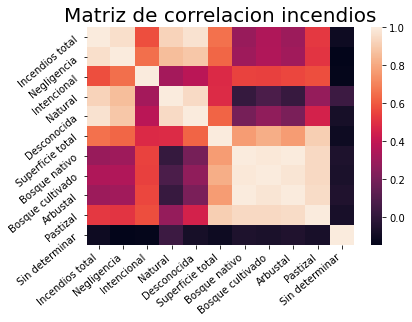

In [18]:
#Generamos un Mapa de correlación. 
incendiosporprovincia_corr=incendios_provincias.corr()
corr_c_plot = sns.heatmap(incendiosporprovincia_corr, xticklabels=1, yticklabels=1)
corr_c_plot.set_xticklabels(labels=('Incendios total','Negligencia','Intencional','Natural', 'Desconocida', 'Superficie total', 'Bosque nativo','Bosque cultivado','Arbustal','Pastizal', 'Sin determinar'), rotation=40, ha="right")
corr_c_plot.set_yticklabels(labels=('Incendios total','Negligencia','Intencional','Natural', 'Desconocida', 'Superficie total', 'Bosque nativo','Bosque cultivado','Arbustal','Pastizal', 'Sin determinar'), rotation=40, ha="right")

plt.title("Matriz de correlacion incendios", size=20)
plt.show()

No podemos sacar muchas conclusiones. Si podemos decir que a mayor cantidad de incendios mayor es la superficie afectada.

In [19]:
#A continuación, las provincias ordenadas por cantidad de incendios (de mayor a menor)
idx_top = incendios_provincias['incendio_total_numero'].sort_values(ascending=False)
idx_top

provincia
Buenos Aires           74968
Río Negro              30916
Santa Fe               21011
Salta                  17004
Córdoba                 8470
Chaco                   7848
Misiones                6974
San Juan                6386
Entre Ríos              5033
Chubut                  3684
Neuquén                 3394
Corrientes              3261
Catamarca               3214
Jujuy                   3187
Tucumán                 3000
Mendoza                 2487
La Rioja                1680
Santiago del Estero     1516
Formosa                 1497
La Pampa                1418
San Luis                1096
Tierra del Fuego         570
Santa Cruz               515
CABA                      54
Name: incendio_total_numero, dtype: int64

Las 5 provincias con mayor cantidad de incendios son: Buenos Aires, Río Negro, Santa Fe, Salta y Córdoba.

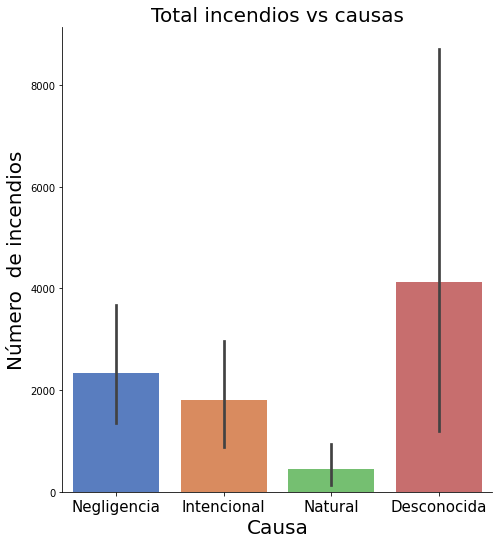

In [20]:
# observamos cantidad de incendios vs causas de ocurrencia
incendios_provincias_sin_total=incendios_provincias.drop(['incendio_total_numero'],axis=1).iloc[:, :4]
g2= sns.catplot(data=incendios_provincias_sin_total, kind="bar", height = 7 ,aspect=1,palette = "muted")
g2.set_xticklabels(labels=('Negligencia','Intencional','Natural', 'Desconocida'),size=15)
plt.xlabel("Causa",size=20)
plt.ylabel("Número  de incendios",size=20)
plt.title('Total incendios vs causas',size = 20)
plt.show()

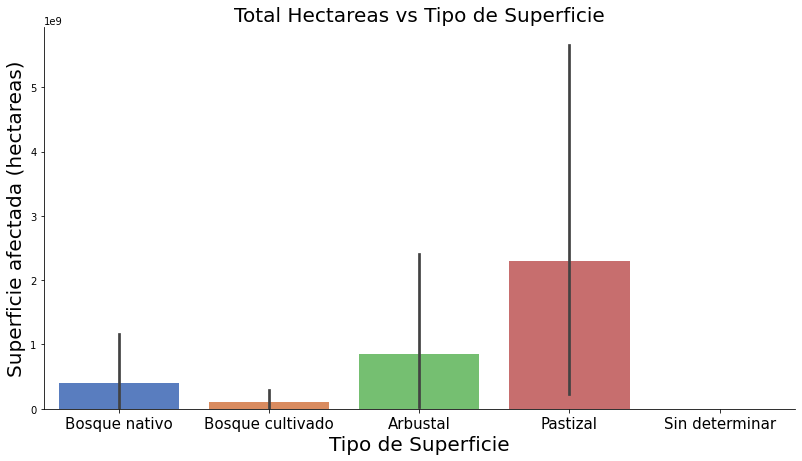

In [21]:
#Total de hectareas afectadas vs tipo de superficie
incendios_provincias_sin_total=incendios_provincias.iloc[:, 6:]
g2= sns.catplot(data=incendios_provincias_sin_total, kind="bar", height = 6 ,aspect=2.1,palette = "muted")
g2.set_xticklabels(labels=('Bosque nativo','Bosque cultivado','Arbustal','Pastizal', 'Sin determinar'),size=15)
plt.xlabel("Tipo de Superficie",size=20)
plt.ylabel("Superficie afectada (hectareas)",size=20)
plt.title('Total Hectareas vs Tipo de Superficie',size = 20)
plt.show()

In [22]:
#Superficie promedio afectada por provincia por año
df_df1['superficie_afectada_promedio_por_incendio']=df_df1.superficie_afectada_por_incendios_total_hectareas/df_df1.incendio_total_numero
df_df1=df_df1.fillna(0)
df_df1.head()

,year,provincia,incendio_total_numero,incendio_negligencia_numero,incendio_intencional_numero,incendio_natural_numero,incendio_desconocida_numero,superficie_afectada_por_incendios_total_hectareas,superficie_afectada_por_incendios_bosque_nativo_hectareas,superficie_afectada_por_incendios_bosque_cultivado_hectareas,superficie_afectada_por_incendios_arbustal_hectareas,superficie_afectada_por_incendios_pastizal_hectareas,superficie_afectada_por_incendios_sin_determinar_hectareas,superficie_afectada_promedio_por_incendio
0,1993.0,Buenos Aires,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.000000
1,1993.0,Catamarca,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.000000
2,1993.0,Chaco,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.000000
3,1993.0,Chubut,21,18.0,0.0,0.0,3.0,149.5,10.0,6.25,0.0,133.25,0.0,7.119048
4,1993.0,Córdoba,151,0.0,0.0,0.0,151.0,232941.0,59995.0,250.00,0.0,172696.00,0.0,1542.655629


In [23]:
#Generamos un nuevo dataframe para conocer el porcentaje de causas por provincias. Y lo visualizamos en graficos circulares
porcentaje_causas= pd.DataFrame(columns=['Total','Porcentaje_Intencional','Porcentaje_Negligencia','Porcentaje_Natural','Porcentaje_Desconocida'])
porcentaje_causas.Total=incendios_provincias.incendio_total_numero.sort_values(ascending=False)
porcentaje_causas.Porcentaje_Intencional=((incendios_provincias.incendio_intencional_numero*100)/incendios_provincias.incendio_total_numero).astype(float)
porcentaje_causas.Porcentaje_Negligencia=((incendios_provincias.incendio_negligencia_numero*100)/incendios_provincias.incendio_total_numero).astype(float)
porcentaje_causas.Porcentaje_Natural=((incendios_provincias.incendio_natural_numero*100)/incendios_provincias.incendio_total_numero).astype(float)
porcentaje_causas.Porcentaje_Desconocida=((incendios_provincias.incendio_desconocida_numero*100)/incendios_provincias.incendio_total_numero).astype(float)
porcentaje_causas.head()

,Total,Porcentaje_Intencional,Porcentaje_Negligencia,Porcentaje_Natural,Porcentaje_Desconocida
provincia,,,,,
Buenos Aires,74968,5.858500,18.543912,7.020329,68.577260
Río Negro,30916,29.858326,22.150343,1.753138,46.238194
Santa Fe,21011,52.115559,27.709295,3.902718,16.272429
Salta,17004,12.526464,30.563397,9.744766,47.165373
Córdoba,8470,40.507674,41.900826,0.554900,17.036600


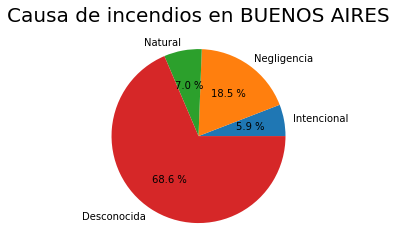

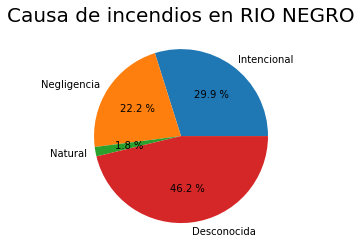

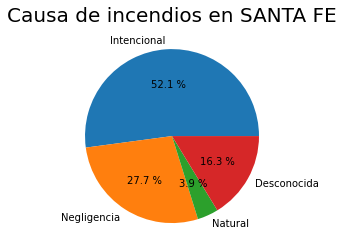

In [24]:
plt.pie(x=[5.858500,18.543912,7.020329,68.577260],labels=['Intencional','Negligencia','Natural','Desconocida'],autopct="%0.1f %%")
plt.title("Causa de incendios en BUENOS AIRES",size=20)
plt.show()
plt.pie(x=[29.858326,22.150343,1.753138,46.238194],labels=['Intencional','Negligencia','Natural','Desconocida'],autopct="%0.1f %%")
plt.title("Causa de incendios en RIO NEGRO",size=20)
plt.show()
plt.pie(x=[52.115559,27.709295,3.902718,16.272429],labels=['Intencional','Negligencia','Natural','Desconocida'],autopct="%0.1f %%")
plt.title("Causa de incendios en SANTA FE",size=20)
plt.show()

In [25]:
#Hacemos lo mismo para porcentaje de superficie por provincia
porcentaje_superficie= pd.DataFrame(columns=['Total','Porcentaje_Bosque_Nativo','Porcentaje_Bosque_Cultivado','Porcentaje_Arbustal','Porcentaje_Pastizal', 'Porcentaje_sin_determinar'])
porcentaje_superficie.Total=incendios_provincias.iloc[:,6:].sum(axis=1,numeric_only=True,min_count=0,skipna=True).sort_values(ascending=False)
porcentaje_superficie.Porcentaje_Bosque_Nativo=((incendios_provincias.superficie_afectada_por_incendios_bosque_nativo_hectareas*100)/porcentaje_superficie.Total).astype(float)
porcentaje_superficie.Porcentaje_Bosque_Cultivado=((incendios_provincias.superficie_afectada_por_incendios_bosque_cultivado_hectareas*100)/porcentaje_superficie.Total).astype(float)
porcentaje_superficie.Porcentaje_Arbustal=((incendios_provincias.superficie_afectada_por_incendios_arbustal_hectareas*100)/porcentaje_superficie.Total).astype(float)
porcentaje_superficie.Porcentaje_Pastizal=((incendios_provincias.superficie_afectada_por_incendios_pastizal_hectareas*100)/porcentaje_superficie.Total).astype(float)
porcentaje_superficie.Porcentaje_sin_determinar=((incendios_provincias.superficie_afectada_por_incendios_sin_determinar_hectareas*100)/porcentaje_superficie.Total).astype(float)
porcentaje_superficie.head()

,Total,Porcentaje_Bosque_Nativo,Porcentaje_Bosque_Cultivado,Porcentaje_Arbustal,Porcentaje_Pastizal,Porcentaje_sin_determinar
provincia,,,,,,
Río Negro,6.138104e+10,12.748221,2.922152,28.811262,55.518364,0.000000e+00
Buenos Aires,1.065293e+10,0.779576,1.607310,2.236731,95.376383,9.387085e-08
Chubut,6.973783e+09,21.207707,8.058225,28.782353,41.951716,0.000000e+00
Neuquén,6.567929e+09,1.490875,0.526484,7.202163,90.780478,1.196724e-09
Catamarca,1.098122e+09,0.146458,0.101630,8.233086,91.518826,0.000000e+00


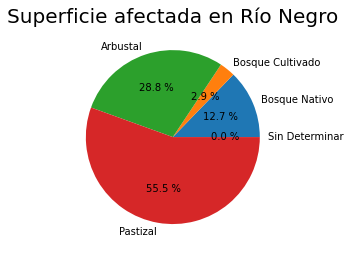

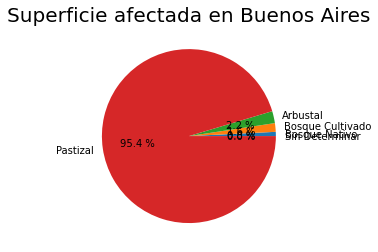

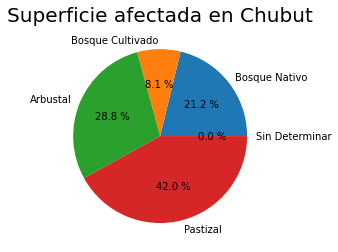

In [26]:
plt.pie(x=[12.748221,2.922152,28.811262,55.518364,0.000000e+00],labels=['Bosque Nativo','Bosque Cultivado','Arbustal','Pastizal','Sin Determinar'],autopct="%0.1f %%")
plt.title("Superficie afectada en Río Negro",size=20)
plt.show()
plt.pie(x=[0.779576	,1.607310,2.236731,95.376383,9.387085e-08],labels=['Bosque Nativo','Bosque Cultivado','Arbustal','Pastizal','Sin Determinar'],autopct="%0.1f %%")
plt.title("Superficie afectada en Buenos Aires",size=20)
plt.show()
plt.pie(x=[21.207707,8.058225,28.782353,41.951716,0.000000e+00],labels=['Bosque Nativo','Bosque Cultivado','Arbustal','Pastizal','Sin Determinar'],autopct="%0.1f %%")
plt.title("Superficie afectada en Chubut",size=20)
plt.show()


In [27]:
#Pasamos a analizar a Bs As por ser la provincia con mayor cantidad de incendios
incendios_buenosaires=df_df1.loc[df_df1.provincia=='Buenos Aires']
incendios_buenosaires.head(3)

,year,provincia,incendio_total_numero,incendio_negligencia_numero,incendio_intencional_numero,incendio_natural_numero,incendio_desconocida_numero,superficie_afectada_por_incendios_total_hectareas,superficie_afectada_por_incendios_bosque_nativo_hectareas,superficie_afectada_por_incendios_bosque_cultivado_hectareas,superficie_afectada_por_incendios_arbustal_hectareas,superficie_afectada_por_incendios_pastizal_hectareas,superficie_afectada_por_incendios_sin_determinar_hectareas,superficie_afectada_promedio_por_incendio
0,1993.0,Buenos Aires,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,1994.0,Buenos Aires,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,1995.0,Buenos Aires,1,0.0,0.0,0.0,1.0,3000.0,0.0,0.0,0.0,3000.0,0.0,3000.0


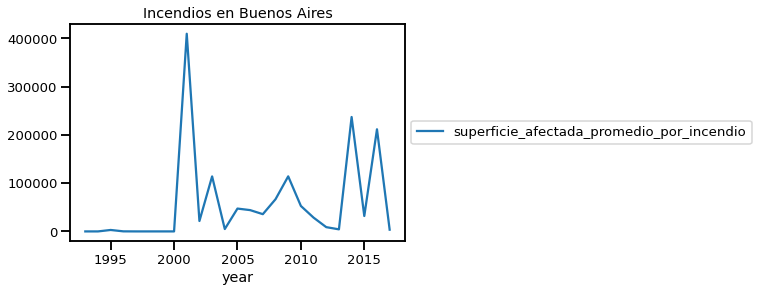

In [28]:
sns.set_context("talk", font_scale=0.8)
incendios_buenosaires.iloc[:,[0,13]].plot(title = "Incendios en Buenos Aires",x='year' )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

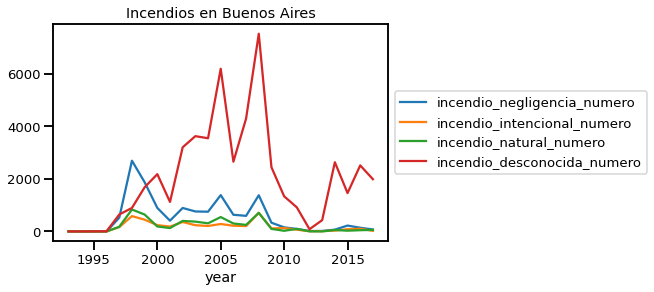

In [29]:
sns.set_context("talk", font_scale=0.8)
incendios_buenosaires.iloc[:,:7].drop(['incendio_total_numero'],axis=1).plot(title = "Incendios en Buenos Aires",x='year' )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [30]:
#Buscamos hacer un análisis de la provincia con mayor cantidad de incendios intencionales
incendios_intencionales=incendios_provincias.incendio_intencional_numero.sort_values(ascending=False)
incendios_intencionales

provincia
Santa Fe               10950.0
Río Negro               9231.0
Buenos Aires            4392.0
Córdoba                 3431.0
San Juan                2695.0
Salta                   2130.0
Catamarca               2000.0
Chaco                   1713.0
Chubut                  1217.0
Entre Ríos              1143.0
Mendoza                 1047.0
Misiones                 856.0
Corrientes               499.0
Tucumán                  459.0
Neuquén                  334.0
San Luis                 311.0
Formosa                  278.0
Santiago del Estero      266.0
Jujuy                    149.0
La Rioja                 114.0
La Pampa                  76.0
Santa Cruz                38.0
Tierra del Fuego          23.0
CABA                       2.0
Name: incendio_intencional_numero, dtype: float64

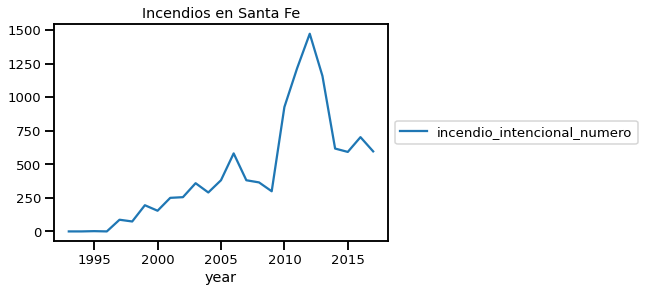

In [31]:
#Procedemos a analizar Santa Fe, por ser la provincia con mayor cantidad de incendios intencionales
incendios_santafe=df_df1.loc[df_df1.provincia=='Santa Fe']
sns.set_context("talk", font_scale=0.8)
incendios_santafe.iloc[:,[0,4]].plot(title = "Incendios en Santa Fe",x='year' )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [32]:
incendios_santafe['estimación_superficie_afectada_por_incendio_intencional']=incendios_santafe.superficie_afectada_promedio_por_incendio*incendios_santafe.incendio_intencional_numero
incendios_santafe.iloc[:,[0,2,4,7,13,14]].tail(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,year,incendio_total_numero,incendio_intencional_numero,superficie_afectada_por_incendios_total_hectareas,superficie_afectada_promedio_por_incendio,estimación_superficie_afectada_por_incendio_intencional
533,2015.0,1047,592.0,1177.0,1.124164,665.505253
557,2016.0,1241,702.0,1107.0,0.892023,626.199839
581,2017.0,1096,596.0,1303.0,1.188869,708.565693


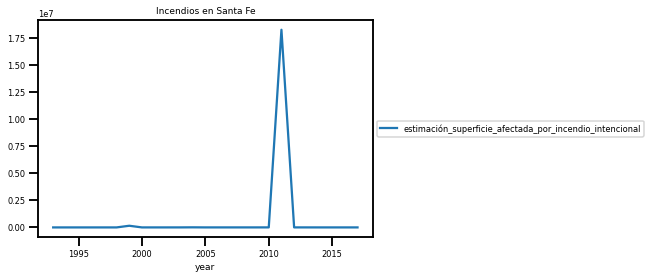

In [33]:
sns.set_context("talk", font_scale=0.5)
incendios_santafe.iloc[:,[0,14]].plot(title = "Incendios en Santa Fe",x='year')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [34]:
#En el 2011 se genero la mayor estimacion aunque no tenga la mayor cantidad de incendios intencionales por lo que tal vez deberiamos desestimar lo calculado anteriormente
incendios_santafe.estimación_superficie_afectada_por_incendio_intencional.sort_values(ascending=False)
incendios_santafe.iloc[:,[0,4,14]]

,year,incendio_intencional_numero,estimación_superficie_afectada_por_incendio_intencional
19,1993.0,0.0,0.000000e+00
42,1994.0,0.0,0.000000e+00
65,1995.0,2.0,0.000000e+00
87,1996.0,0.0,0.000000e+00
110,1997.0,87.0,1.086396e+02
133,1998.0,74.0,1.310315e+02
155,1999.0,195.0,1.535456e+05
179,2000.0,154.0,4.936989e+02
203,2001.0,250.0,9.385759e+02
226,2002.0,255.0,7.962101e+02


Análisis de Río Negro por ser la provincia con mayor superficie afectada

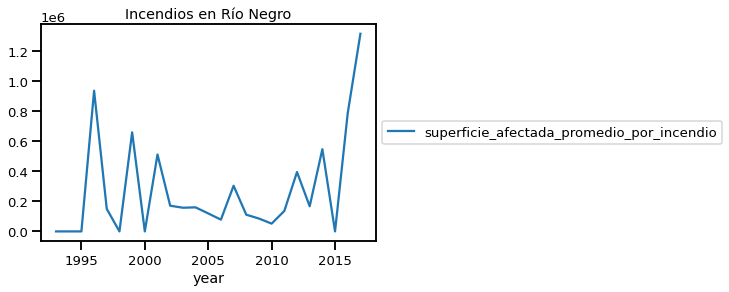

In [35]:
#Análisis de Río Negro por ser la provincia con mayor superficie afectada
incendios_rionegro=df_df1.loc[df_df1.provincia=='Río Negro']
sns.set_context("talk", font_scale=0.8)
incendios_rionegro.iloc[:,[0,13]].plot(title = "Incendios en Río Negro",x='year' )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

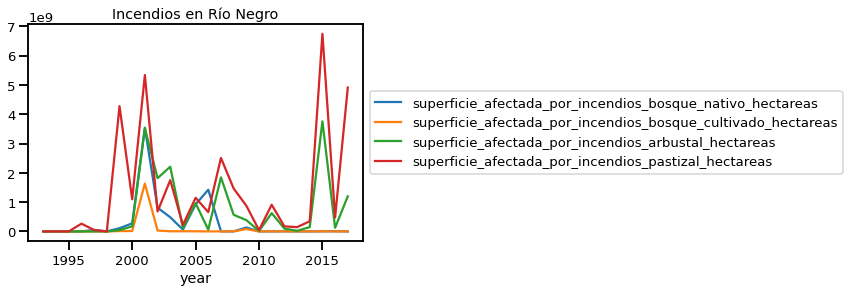

In [36]:
sns.set_context("talk", font_scale=0.8)
incendios_rionegro.iloc[:,[0,8,9,10,11]].plot(title = "Incendios en Río Negro",x='year' )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

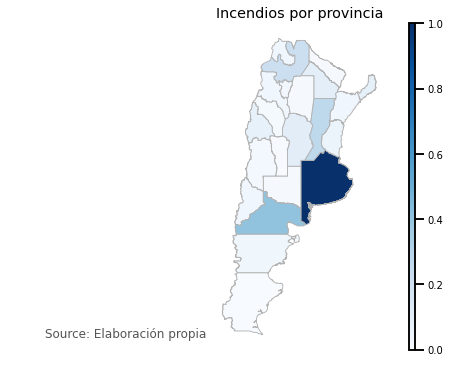

In [37]:
# Visualizamos cantidad de incendios por provincia.
provincias1=map_data.rename(columns={'nam':'provincia'})#Renombramos el mapa para hacer coincidir 
provincias1=pd.merge(incendios_provincias, provincias1, on=['provincia'])
provincias1 = GeoDataFrame(provincias1)
provincias1['incendio_total_numero']=provincias1['incendio_total_numero'].astype(int)

vmin, vmax = 0, 1
fig, ax = plt.subplots(1, figsize=(10, 6))
provincias1.plot(column='incendio_total_numero',cmap='Blues', linewidth=0.9, ax=ax, edgecolor='0.7')
plt.title("Incendios por provincia")
plt.axis('off')
plt.annotate('Source: Elaboración propia',xy=(0.1, .12),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=10) 
plt.show()

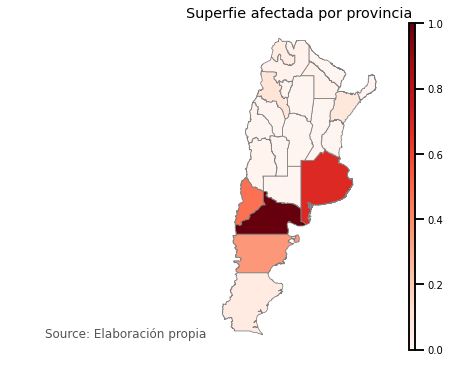

In [38]:
#Visualizamos cantidad de Hectáreas afectadas por provincia
vmin, vmax = 0, 1
fig, ax = plt.subplots(1, figsize=(10, 6))
provincias1.plot(column='superficie_afectada_por_incendios_total_hectareas',cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.5')
plt.title("Superfie afectada por provincia")
plt.axis('off')
plt.annotate('Source: Elaboración propia',xy=(0.1, .12),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=10) 
plt.show()